Import dataset

In [ ]:
import pandas as pd
import os
from ydata_profiling import ProfileReport
from scripts import DProcess_lib

# Create the directory if it does not exist
'''directory_name = "EDA_report_Titanic"
if not os.path.exists(directory_name):
    os.makedirs(directory_name)'''

# Import data
data_path_train = "data_Titanic/train.csv"
data_path_test = "data_Titanic/test.csv"
df_train = pd.read_csv(data_path_train)
df_test = pd.read_csv(data_path_test)

# Generate the data profiling report
'''path = "EDA_reports/Titanic_report.html"
if not os.path.exists(path):
    report = ProfileReport(df, title='Titanic Data')
    report.to_file(path)'''

print(df_train.head(5))

df = pd.concat([df_train, df_test])

print(df_train.shape)
print(df_test.shape)
print(df.shape)

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
(8

set id as index

In [20]:
# set PassengerId as index
df = df.set_index('PassengerId', drop=True)

# check nans
print(df.isna().sum())


Survived     418
Pclass         0
Name           0
Sex            0
Age          263
SibSp          0
Parch          0
Ticket         0
Fare           1
Cabin       1014
Embarked       2
dtype: int64


remove unwanted data (Name=> not relevant, Cabin=> not relevant and contain lot of missing data, Ticket=> Pclass contain the important ticket information)

In [21]:
df = df.drop(columns=['Name', 'Cabin', 'Ticket'])

#check result
print(df.shape[0])
print(df.isna().sum())

1309
Survived    418
Pclass        0
Sex           0
Age         263
SibSp         0
Parch         0
Fare          1
Embarked      2
dtype: int64


missing ages are not calculatable, embarked is only 2 elements, so remove rows with nans

In [22]:
df = df.dropna()
print(df.shape[0])

712


we will create 3 dataframes and 1 series, 1 original dataframe, 1 dataframe with encoded labels and original numbers, 1 dataframe with encoded labels and scaled numbers, series with target

In [23]:
X_original = df.drop(columns=['Survived'])
to_encode = X_original[['Sex', 'Embarked', 'Pclass']]
to_scale = X_original[['Age', 'SibSp','Parch', 'Fare']]
y = df['Survived']
print(y)


PassengerId
1      0.0
2      1.0
3      1.0
4      1.0
5      0.0
      ... 
886    0.0
887    0.0
888    1.0
890    1.0
891    0.0
Name: Survived, Length: 712, dtype: float64


Check outliers on numerical data

In [24]:
from scipy.stats import zscore

# Calculate Z-scores for each column and count the number of outliers
for column in to_scale.columns:
    z_scores = zscore(to_scale[column])
    outliers_count = (abs(z_scores) > 2.5).sum()  # Count the number of outliers
    print(f"{column}: {outliers_count} outliers")



Age: 8 outliers
SibSp: 35 outliers
Parch: 15 outliers
Fare: 18 outliers


Age is possible to limit
SibSp and Parch contain information, we dont limit it
Fare is possible to limit

create limitations

In [25]:

print("Before")
print(to_scale['Age'].min(), to_scale['Age'].max())
print(to_scale['Fare'].min(), to_scale['Fare'].max())

columns = ['Age', 'Fare']
for column in columns:
    z_scores = zscore(to_scale[column])
    
    # Find the threshold values for Z-scores of ±3
    upper_limit = to_scale[column].mean() + 2.5 * to_scale[column].std()
    lower_limit = to_scale[column].mean() - 2.5 * to_scale[column].std()
    
    # Cap values in the column based on these limits using .loc
    to_scale.loc[z_scores > 3, column] = upper_limit
    to_scale.loc[z_scores < -3, column] = lower_limit

print("After")
print(to_scale['Age'].min(), to_scale['Age'].max())
print(to_scale['Fare'].min(), to_scale['Fare'].max())

Before
0.42 80.0
0.0 512.3292
After
0.42 71.0
0.0 166.9138718412716


encode

In [26]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False, drop=None)
encoded_array = encoder.fit_transform(to_encode)

# Convert the encoded array to a DataFrame
encoded = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(to_encode.columns))

# Concatenate with to_scale DataFrame
X_encoded = pd.concat([encoded, to_scale.reset_index(drop=True)], axis=1)
print(X_encoded)




     Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  Pclass_1  \
0           0.0       1.0         0.0         0.0         1.0       0.0   
1           1.0       0.0         1.0         0.0         0.0       1.0   
2           1.0       0.0         0.0         0.0         1.0       0.0   
3           1.0       0.0         0.0         0.0         1.0       1.0   
4           0.0       1.0         0.0         0.0         1.0       0.0   
..          ...       ...         ...         ...         ...       ...   
707         1.0       0.0         0.0         1.0         0.0       0.0   
708         0.0       1.0         0.0         0.0         1.0       0.0   
709         1.0       0.0         0.0         0.0         1.0       1.0   
710         0.0       1.0         1.0         0.0         0.0       1.0   
711         0.0       1.0         0.0         1.0         0.0       0.0   

     Pclass_2  Pclass_3   Age  SibSp  Parch     Fare  
0         0.0       1.0  22.0      1      0 

check distribution

[[<Axes: title={'center': 'Age'}> <Axes: title={'center': 'SibSp'}>]
 [<Axes: title={'center': 'Parch'}> <Axes: title={'center': 'Fare'}>]]


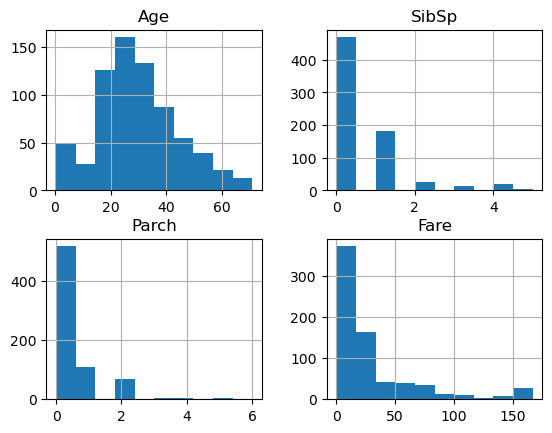

In [27]:
print(to_scale.hist())

normalise data

In [28]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled =pd.DataFrame(scaler.fit_transform(to_scale), columns=to_scale.columns)
X_encoded_scaled = pd.concat([scaled, encoded.reset_index(drop=True)], axis=1)
print(X_encoded_scaled)

          Age  SibSp     Parch      Fare  Sex_female  Sex_male  Embarked_C  \
0    0.305752    0.2  0.000000  0.043436         0.0       1.0         0.0   
1    0.532445    0.2  0.000000  0.427066         1.0       0.0         1.0   
2    0.362426    0.0  0.000000  0.047480         1.0       0.0         0.0   
3    0.489940    0.2  0.000000  0.318128         1.0       0.0         0.0   
4    0.489940    0.0  0.000000  0.048228         0.0       1.0         0.0   
..        ...    ...       ...       ...         ...       ...         ...   
707  0.546614    0.0  0.833333  0.174491         1.0       0.0         0.0   
708  0.376594    0.0  0.000000  0.077884         0.0       1.0         0.0   
709  0.263247    0.0  0.000000  0.179733         1.0       0.0         0.0   
710  0.362426    0.0  0.000000  0.179733         0.0       1.0         1.0   
711  0.447436    0.0  0.000000  0.046431         0.0       1.0         0.0   

     Embarked_Q  Embarked_S  Pclass_1  Pclass_2  Pclass_3  
0  

Results

In [29]:
print("--------------------------------------")
print("Original data, unwanted colums are removed, nans are removed")
print(X_original.head(5))
print("--------------------------------------")
print("Categories are converted")
print(X_encoded.head(5))
print("--------------------------------------")
print("Categories are converted, numbers are scaled")
print(X_encoded_scaled.head(5))
print("--------------------------------------")
print("y")
print(y.head(5))
print(y.shape, X_original.shape, X_encoded.shape, X_encoded_scaled.shape)

--------------------------------------
Original data, unwanted colums are removed, nans are removed
             Pclass     Sex   Age  SibSp  Parch     Fare Embarked
PassengerId                                                      
1                 3    male  22.0      1      0   7.2500        S
2                 1  female  38.0      1      0  71.2833        C
3                 3  female  26.0      0      0   7.9250        S
4                 1  female  35.0      1      0  53.1000        S
5                 3    male  35.0      0      0   8.0500        S
--------------------------------------
Categories are converted
   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  Pclass_1  \
0         0.0       1.0         0.0         0.0         1.0       0.0   
1         1.0       0.0         1.0         0.0         0.0       1.0   
2         1.0       0.0         0.0         0.0         1.0       0.0   
3         1.0       0.0         0.0         0.0         1.0       1.0   
4        

### export result

In [30]:
import joblib

# Create a dictionary to store all splits
data_splits = {
    "X_original": X_original,
    "X_encoded": X_encoded,
    "X_encoded_scaled": X_encoded_scaled,
    "y": y,
}

joblib.dump(data_splits, 'preprocessed_data\\Titanic.pkl')

['preprocessed_data\\Titanic.pkl']